In [158]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from scipy.ndimage import grey_dilation

In [159]:
#vamos aprende ler uma colecao de figuras

# Listar arquivos .png na pasta atual
current_directory = os.getcwd()+"/figuras/"
event_files = [f for f in os.listdir(current_directory) if (f.endswith('.png') and ("event" in f) and ("nue" in f))]
hit_files=[f for f in os.listdir(current_directory) if (f.endswith('.png') and ("hit" in f) and ("nue" in f))]

event_files=sorted(event_files)
hit_files=sorted(hit_files)

In [215]:
n_figuras=2500
n_total=len(event_files)

random=np.random.choice(n_total,n_figuras,replace=False)

x=[]
y=[]
x_teste=[]


x_end=128#188
y_end=512#610

structure = np.ones((3, 3), dtype=np.uint8)  # Elemento estruturante 3x3

for j in range(n_figuras):
    x.append(np.divide(grey_dilation(np.array(Image.open(current_directory+event_files[random[j]]).convert('L'), dtype=np.uint8)[0:x_end,0:y_end],footprint=structure),215))
    y.append(np.divide(np.array(Image.open(current_directory+hit_files[random[j]]).convert('L'))[0:x_end,0:y_end],215))
    #y.append(x[j])

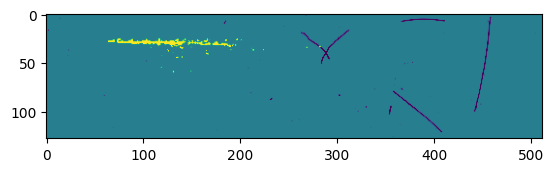

In [217]:
plt.imshow(y_train[index])

In [216]:
#separando em treino e teste dados

x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=12)
#x_train,x_test,y_train,y_test = train_test_split(x,x_teste,random_state=42)
x_train=np.array(x_train)
x_test=np.array(x_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

x_train = x_train.reshape((-1, x_end,y_end, 1))
x_test = x_test.reshape((-1, x_end,y_end, 1))
y_train = y_train.reshape((-1, x_end,y_end, 1))
y_test = y_test.reshape((-1, x_end,y_end, 1))

x=None
y=None


In [163]:
class ResizeLayer(tf.keras.layers.Layer):
    def __init__(self, target_size):
        super(ResizeLayer, self).__init__()
        self.target_size = target_size

    def call(self, inputs):
        return tf.image.resize(inputs, self.target_size)

In [164]:

encoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (5, 5), kernel_initializer="he_normal", padding='same', input_shape=(x_end, y_end, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer="he_normal", padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), kernel_initializer="he_normal", padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same')
])

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, (3, 3), kernel_initializer="he_normal", padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), kernel_initializer="he_normal", padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer="he_normal", padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.UpSampling2D((2, 2)), 
    tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', kernel_initializer="he_normal", padding='same')
])

autoencoder2 = tf.keras.Sequential([encoder, decoder])
autoencoder2.summary()


autoencoder2.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_31 (Sequential)      │ (None, 16, 64, 256)    │       372,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_32 (Sequential)      │ (None, 128, 512, 1)    │     1,485,569 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,858,049 (7.09 MB)

 Trainable params: 1,856,257 (7.08 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [172]:
history = autoencoder2.fit(x_train,y_train, epochs=50, batch_size=10, validation_data=[x_test,y_test])

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 343s 5s/step - loss: 5.7401e-04 - val_loss: 8.4464e-04
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 348s 5s/step - loss: 5.2202e-04 - val_loss: 8.8915e-04
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 347s 5s/step - loss: 6.2456e-04 - val_loss: 0.0012
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 347s 5s/step - loss: 5.3736e-04 - val_loss: 0.0013
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 346s 5s/step - loss: 5.2506e-04 - val_loss: 0.0016
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 347s 5s/step - loss: 4.8044e-04 - val_loss: 8.9432e-04
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 346s 5s/step - loss: 5.8280e-04 - val_loss: 7.4019e-04
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 360s 5s/step - loss: 4.9841e-04 - val_loss: 8.7750e-04
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 349s 5s/step - loss: 4.8632e-04 - val_loss: 0.0011
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 347s 5s/step - loss: 4.8847e-04 - val_loss: 0.0012
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 347s 5s/step - loss: 4.7107e-04 - val_loss: 0.0015

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


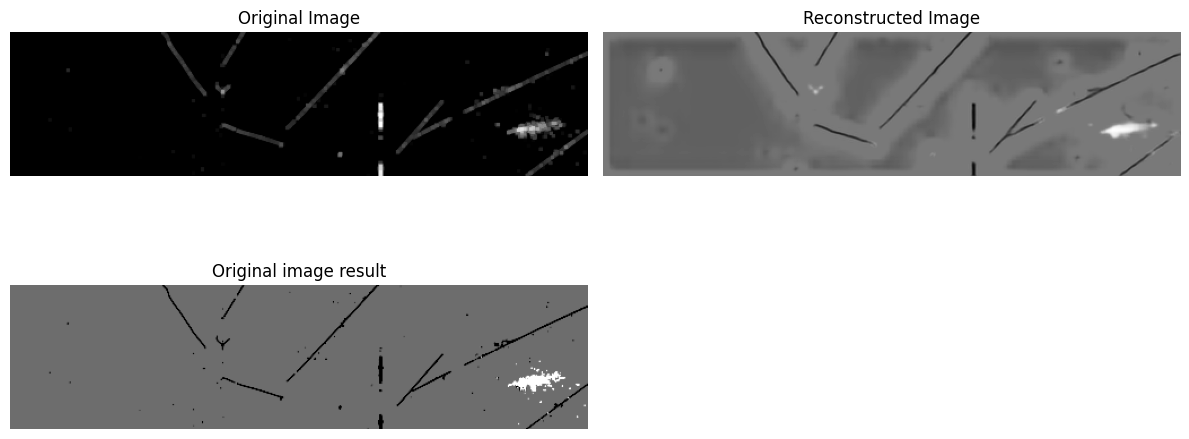

In [231]:
index=8
a=autoencoder2.predict(np.expand_dims(x_test[index], axis=0))
# Visualizar o primeiro exemplo
plt.figure(figsize=(12, 6))
# Exibir a imagem original
plt.subplot(2, 2, 1)
plt.imshow(x_test[index], cmap='gray')  # Adapte o cmap se necessário
plt.title('Original Image')
plt.axis('off')  # Desliga os eixos
# Exibir a imagem reconstruída
plt.subplot(2, 2, 2)
plt.imshow(a[0], cmap='gray')  # Adapte o cmap se necessário
plt.title('Reconstructed Image')
plt.axis('off')  # Desliga os eixos
# Mostrar as imagens
plt.tight_layout()
# Exibir a imagem reconstruída
plt.subplot(2, 2, 3)
plt.imshow(y_test[index], cmap='gray')  # Adapte o cmap se necessário
plt.title('Original image result')
plt.axis('off')  # Desliga os eixos
# Mostrar as imagens
plt.tight_layout()
plt.show()




In [177]:
#autoencoder2.save('this_neutrino_autoencoder.h5')

In [178]:
loaded_autoencoder = tf.keras.models.load_model('this_neutrino_autoencoder.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


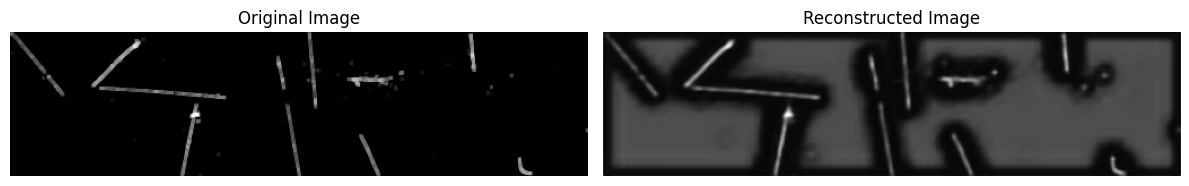

In [187]:
index=5
a=loaded_autoencoder.predict(np.expand_dims(x_train[index], axis=0))
# Visualizar o primeiro exemplo
plt.figure(figsize=(12, 6))
# Exibir a imagem original
plt.subplot(1, 2, 1)
plt.imshow(x_train[index], cmap='gray')  # Adapte o cmap se necessário
plt.title('Original Image')
plt.axis('off')  # Desliga os eixos
# Exibir a imagem reconstruída
plt.subplot(1, 2, 2)
plt.imshow(a[0], cmap='gray')  # Adapte o cmap se necessário
plt.title('Reconstructed Image')
plt.axis('off')  # Desliga os eixos
# Mostrar as imagens
plt.tight_layout()
plt.show()

In [181]:
# Congelando as camadas do decoder
for layer in encoder.layers:
    layer.trainable = False


autoencoder2.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

In [221]:
history = autoencoder2.fit(x_train,y_train, epochs=50, batch_size=10, validation_data=[x_test,y_test])

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 570s 3s/step - loss: 8.4994e-04 - val_loss: 0.0029
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 574s 3s/step - loss: 8.7461e-04 - val_loss: 0.0045
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 608s 3s/step - loss: 8.4791e-04 - val_loss: 0.0038
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 707s 4s/step - loss: 8.5360e-04 - val_loss: 0.0046
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 699s 4s/step - loss: 8.5221e-04 - val_loss: 0.0050
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 702s 4s/step - loss: 8.5306e-04 - val_loss: 0.0030
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 708s 4s/step - loss: 8.4190e-04 - val_loss: 0.0034
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 650s 3s/step - loss: 8.2638e-04 - val_loss: 0.0034
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 573s 3s/step - loss: 8.3289e-04 - val_loss: 0.0048
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 575s 3s/step - loss: 8.1192e-04 - val_loss: 0.0042
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 562s 3s/step - loss: 8.2510e-04 - val_loss: 0.00

In [233]:
autoencoder2.save('this_neutrino_autoencoder_4.h5')

In [242]:
x_save=None
y_save=None

n_figuras=len(event_files)
x_end=128#188
y_end=512#610

structure = np.ones((3, 3), dtype=np.uint8)  # Elemento estruturante 3x3

for j in range(10):
    x_save=np.divide(grey_dilation(np.array(Image.open(current_directory+event_files[j]).convert('L'), dtype=np.uint8)[0:x_end,0:y_end],footprint=structure),215)
    y_save=np.divide(np.array(Image.open(current_directory+hit_files[j]).convert('L'))[0:x_end,0:y_end],215)
    
    x_save=np.array(x_save)
    x_save = x_save.reshape((-1, x_end,y_end, 1))

    y_save=np.array(y_save)
    y_save = y_save.reshape((-1, x_end,y_end, 1))

    filename=os.path.splitext(event_files[j])[0]
    a=autoencoder2.predict(x_save)
    # Visualizar o primeiro exemplo
    plt.figure(figsize=(12, 6))
    # Exibir a imagem original
    plt.subplot(2, 2, 1)
    plt.imshow(x_save[0,:], cmap='gray')  # Adapte o cmap se necessário
    plt.title('Original Image')
    plt.axis('off')  # Desliga os eixos
    # Exibir a imagem reconstruída
    plt.subplot(2, 2, 2)
    plt.imshow(a[0], cmap='gray')  # Adapte o cmap se necessário
    plt.title('Reconstructed Image')
    plt.axis('off')  # Desliga os eixos
    # Mostrar as imagens
    plt.tight_layout()
    # Exibir a imagem reconstruída
    plt.subplot(2, 2, 3)
    plt.imshow(y_save[0,:], cmap='gray')  # Adapte o cmap se necessário
    plt.title('Original image result')
    plt.axis('off')  # Desliga os eixos
    # Mostrar as imagens
    plt.tight_layout()
    plt.savefig(f"./results/"+filename+".png",  bbox_inches='tight', pad_inches=0)
    plt.clf()  # Limpa a figura para a próxima imagem
                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>